# Reddit Posts Analysis with Natural Language Processing

# Part 2

*Content:*

1. [Data Cleaning & Imports](#Data-Cleaning-&-Imports)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)

*Other notebooks:* 
- [Part 1: Web Scraping](Part_1_Reddit_Analysis_WebScraping.ipynb)
- [Part 2: Data Cleaning & EDA](Part_2_Reddit_Analysis_EDA.ipynb)
- [Part 3: Modeling & Evaluation](Part_3_Reddit_Analysis_Modeling.ipynb)

## Data Cleaning & Imports

### Libraries

In [1]:
import numpy as np
import statistics
import pandas as pd
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import nltk
import gensim
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer

pd.options.display.max_rows = 110
pd.options.display.max_colwidth = 1000

### Loading the dataset

In [2]:
cat_df = pd.read_csv('../datasets/cat_advice_raw.csv')
dog_df = pd.read_csv('../datasets/dog_advice_raw.csv')

In [3]:
# Check dataframe info for r/CatAdvice

cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  3000 non-null   object 
 1   allow_live_comments            3000 non-null   bool   
 2   author                         3000 non-null   object 
 3   author_flair_css_class         0 non-null      float64
 4   author_flair_richtext          2995 non-null   object 
 5   author_flair_text              24 non-null     object 
 6   author_flair_type              2995 non-null   object 
 7   author_fullname                2995 non-null   object 
 8   author_is_blocked              3000 non-null   bool   
 9   author_patreon_flair           2995 non-null   object 
 10  author_premium                 2995 non-null   object 
 11  awarders                       3000 non-null   object 
 12  can_mod_post                   3000 non-null   b

In [4]:
# Check dataframe info for r/DogAdvice

dog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  3000 non-null   object 
 1   allow_live_comments            3000 non-null   bool   
 2   author                         3000 non-null   object 
 3   author_flair_css_class         0 non-null      float64
 4   author_flair_richtext          2992 non-null   object 
 5   author_flair_text              0 non-null      float64
 6   author_flair_type              2992 non-null   object 
 7   author_fullname                2992 non-null   object 
 8   author_is_blocked              3000 non-null   bool   
 9   author_patreon_flair           2992 non-null   object 
 10  author_premium                 2992 non-null   object 
 11  awarders                       3000 non-null   object 
 12  can_mod_post                   3000 non-null   b

### Cleaning the datasets

We'll start off the process by checking a few potentially interesting features that we may be able to investigate further. 

First off, we'll take a look at the `thumbnail` feature - this refers to whether the content was posted by the user, if it has a thumbnail, contains spoiler or NSFW material. ([source](https://www.reddit.com/r/redditdev/comments/a1dn2p/any_documentation_on_post_properties_such_as/))


In [5]:
# Check to see "thumbnail" feature input

cat_df['thumbnail'].value_counts()

self       2937
nsfw         22
default      22
spoiler      19
Name: thumbnail, dtype: int64

In [6]:
dog_df['thumbnail'].value_counts()

self                                                                                1906
nsfw                                                                                 115
default                                                                               68
spoiler                                                                               13
https://b.thumbs.redditmedia.com/ZWVBy0XfI_Rynjk-QkxCBDMqnn0gEea1NtM2bB20WmE.jpg       3
                                                                                    ... 
https://b.thumbs.redditmedia.com/y0O5bMrF6AxNf5i5C4kg8mhdYD-xSZ7G76gyki_pV7w.jpg       1
https://b.thumbs.redditmedia.com/AEsFxv2nUdL_sV4vNC0xvaKXnIYTKxwSVlRvytIM8CI.jpg       1
https://b.thumbs.redditmedia.com/0Geg69pItV1WyAz0jrSUuRlx8jpZC64IGX8aMhuthqE.jpg       1
https://b.thumbs.redditmedia.com/B03aKRwjV-Aho3NUC4eU90bKkue7NtHyqtAspaqgdBQ.jpg       1
https://a.thumbs.redditmedia.com/yKOMtE8zj0uFKNBXhD4vkuht1y3w-2vupnnWVM2bt10.jpg       1
Name: thumbnail, Leng

Seeing that a significant majority of the content were posted by the user, we can omit using this feature.

Let's take a look at `is_self`, which refers to whether a content was posted by the user or links somewhere else

In [7]:
# Check to see "is_self" feature input

cat_df['is_self'].value_counts()

True     2981
False      19
Name: is_self, dtype: int64

In [8]:
dog_df['is_self'].value_counts()

True     1951
False    1049
Name: is_self, dtype: int64

Reaffirming our earlier check, most content was uploaded by the user directly. Hence we won't be using this feature as well. 

Next, we'll be looking at `upvote ratio`, percentage of upvotes on the content.

In [9]:
# Check to see "upvote_ratio" feature input

cat_df['upvote_ratio'].value_counts()

1.00    2987
0.99      13
Name: upvote_ratio, dtype: int64

In [10]:
dog_df['upvote_ratio'].value_counts()

1.00    2987
0.99      13
Name: upvote_ratio, dtype: int64

Based on these, we can see that there's only two types of input and there's little variation. Hence, we likely will not be considering this feature.

We'll also look at `link_flair_text` to look at the different categories of content. 

In [11]:
# Check to see "link_flair_text" feature input

cat_df['link_flair_text'].value_counts()

Behavioral                         1041
General                             762
New to Cats/Just Adopted            309
Nutrition/Water                     232
Litterbox                           220
Sensitive/Seeking Support           180
Introductions                       131
Rehoming                             52
Adoption Regret/Doubt                39
CW: Graphic injuries/death           12
Pet Loss                             10
Meta/update                           7
[I Wrote/Found] A Helpful Guide       4
AMA                                   1
Name: link_flair_text, dtype: int64

In [12]:
dog_df['link_flair_text'].value_counts()

Question      819
Advice        687
Discussion     68
General        31
Answered        2
Name: link_flair_text, dtype: int64

The categories for each dataset are very different, giving us preliminary insights that:
- Most issues cat owners face relate to behaviors and new cats
- In r/CatAdvice, the last two input (`[I Wrote/Found] A Helpful Guide` and `AMA`) seemed suspicious, which could be outliers
- There's not much information from the r/DogAdvice dataset so we may not be able to extract any meaningful insight
- In r/CatAdvice, the last input on `Answered` may also be an outlier

Let's take a look at the potential outliers first:

In [13]:
cat_df[cat_df['link_flair_text'] == '[I Wrote/Found] A Helpful Guide'][['title', 'selftext']]

,title,selftext
30,I traveled with my six-month old kitten and it was wonderful,"Hey all. Traveling with cats is very fraught, and something I thought about for months. Your situation and cat(s) are of course different, but I want to share my experience in case it is helpful.\n\nI have a single, six month spayed kitten (context: she was found at three months old on the street by herself. The shelter was full, so they asked me to foster her. I fostered her for 3.5 weeks, and fell in love. Due to my apartment size and costs, I cannot swing another cat, and she was not bonded to any. I adopted her because she is incredibly independent, friendly, and loving. I play with her at least 1-2 hours a day and am deeply committed to her well-belong).\n\nAnyway. Before I adopted her, I booked a trip for 12 days for Thanksgiving. At first I thought I would hire a pet sitter from a certified/bonded company to visit her twice a day. I arranged for the pet sitter to meet her and visit her on another occasion when I was out for 12 hours.. But the more time went on, the more anxi..."
136,I traveled with my six-month-old kitten and it was wonderful,[removed]
984,My cat has some sort of bump on her lip,My cat has this bump on her lip. I just noticed it and it is new because i looked at some pics from the other day and its not there. I can’t add a picture but it does look like some sort of fluid and it’s pink. i know cats can get pimples but idk what hers is. *pls help*
1503,Best medicine for cat’s ear infection?,[removed]


These do not look like outliers, they were probably wrongly tagged. We can change the tag on these:

In [14]:
cat_df.loc[cat_df['link_flair_text'] == '[I Wrote/Found] A Helpful Guide', 'link_flair_text'] = 'General'

Let's take a look at the next potential outlier:

In [15]:
cat_df[cat_df['link_flair_text'] == 'AMA'][['title', 'selftext']]

,title,selftext
383,Impromptu AMA - Certified Cat Behavior Consultant and Trainer,"Hi! I’m Laura, one of the mods. I am a professional cat behavior consultant. When I’m not modding this sub, I work full time helping cat owners resolve behavior problems in their cats. I can help with anything from aggression to people, litter box issues, fighting between cats, destructive behavior, attention seeking, and more! \n\nI usually hold a scheduled AMA once a month here but I have some free time right now, so I’m going to answer questions from now until ???. If the post isn’t locked, you’re good to ask away. \n\nFor more complex behavior issues, I may refer you to my website: www.pawsitivevibescats.com. I do work with clients virtually, so it doesn’t matter where you are. Otherwise, I’ll try to answer specific questions the best I can. \n\nSo go ahead, ask me anything!"


Unfortunately this is an advertisement, and we'll have to remove it from our dataset.

In [16]:
# Dropping rows tagged with 'AMA'

cat_ama = cat_df[(cat_df['link_flair_text'] == 'AMA')].index
cat_df.drop(cat_ama, axis=0, inplace=True)

Now, let's take a look at the last potential outlier in the r/DogAdvice dataset:

In [17]:
dog_df[dog_df['link_flair_text'] == 'Answered'][['title', 'selftext']]

,title,selftext
1579,Dog Ate EOS Chapstick (coconut kind),NaN
1636,Dog Ate EOS Chapstick (coconut kind),NaN


These are duplicates and the issue is not specified. We won't be able to assess much from this post, so we'll proceed to drop them first.

In [18]:
# Dropping rows tagged with 'Answered'

dog_eos = dog_df[(dog_df['link_flair_text'] == 'Answered')].index
dog_df.drop(dog_eos, axis=0, inplace=True)

In [19]:
# Check to see updated count

cat_df['link_flair_text'].value_counts()

Behavioral                    1041
General                        766
New to Cats/Just Adopted       309
Nutrition/Water                232
Litterbox                      220
Sensitive/Seeking Support      180
Introductions                  131
Rehoming                        52
Adoption Regret/Doubt           39
CW: Graphic injuries/death      12
Pet Loss                        10
Meta/update                      7
Name: link_flair_text, dtype: int64

In [20]:
dog_df['link_flair_text'].value_counts()

Question      819
Advice        687
Discussion     68
General        31
Name: link_flair_text, dtype: int64

After assessing and cleaning this feature, the differences between r/CatAdvice and r/DogAdvice is too big and we won't be able to compare them directly. Therefore, we will not investigate this feature any further.

We'll take a look at the statistic summaries for the rest of the feature:

In [21]:
# View summary statistics for CatAdvice

cat_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
all_awardings,2999,1,[],2999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
allow_live_comments,2999,1,False,2999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,2999,2421,Professional-Draw871,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_css_class,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_richtext,2994,9,[],2971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_text,23,8,:maine_coon:,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_type,2994,2,text,2971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_fullname,2994,2420,t2_systyfit,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_is_blocked,2999,1,False,2999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_patreon_flair,2994,1,False,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# View summary statistics for DogAdvice

dog_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
all_awardings,2998,1,[],2998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
allow_live_comments,2998,1,False,2998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,2998,1216,MetforminShits,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_css_class,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_richtext,2990,1,[],2990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_text,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_flair_type,2990,1,text,2990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_fullname,2990,1215,t2_sl6cwdn3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_is_blocked,2998,1,False,2998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_patreon_flair,2990,1,False,2990,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the summary statistics above, we can remove numerical features with little to no variation that would not have much impact on our modeling process. However, it's interesting to note that these numerical features that we'd assume would be impactful did not show much result:
- `score`: Value based on impact and number of comments
- `num_comments`: Number of comments on the post
- `num_crossposts`: Number of times a reddit post is posted in other subreddits
- `upvote_ratio`: Upvote percentages 

Almost all of the result showed metrics 0 to 1 (across mean, max, min), which doesn't give us enough meaningful information. This does not mean that the posts did not gather much comments/ crossposts, but we would have to manually trawl through the data to obtain the information. Likely this is because the platform owner has blocked users from scraping too much information.

Hence, we've narrowed down the features to below:
1. `subreddit`: Refers to the Reddit channel
2. `title`: Post headline
3. `selftext`: Post body
4. `author`: Reddit member
5. `created_utc`: Time the post was created

The post properties' definition can be found [here](https://www.reddit.com/r/redditdev/comments/a1dn2p/any_documentation_on_post_properties_such_as/).

In [23]:
# Taking only relevant columns and dropping irrelevant columns

cat_df = cat_df[['subreddit', 'title', 'selftext', 'author', 'created_utc']]
dog_df = dog_df[['subreddit', 'title', 'selftext', 'author', 'created_utc']]

In [24]:
# Adding target columns for prediction modeling later, where 1 = CatAdvice_subreddit and 0 = DogAdvice_subreddit

cat_df.insert(0, 'is_cat', 1)
dog_df.insert(0,'is_cat', 0)

In [25]:
# Check for null values

cat_df.isnull().sum().sort_values(ascending=False).head()

selftext     23
is_cat        0
subreddit     0
title         0
author        0
dtype: int64

In [26]:
# View rows with null values

cat_df[(cat_df['selftext'].isnull())]

,is_cat,subreddit,title,selftext,author,created_utc
379,1,CatAdvice,Help Needed- Fever of Unknown Origin in 4mo old Kitten-- Delayed Prolonged Vaccine Reaction???,NaN,Steadyfobbin,1669594154
541,1,CatAdvice,"Our 2 cats (7.5 year old females), littermates who have lived together their whole lives, now have to be separated at all times due to severe aggression towards each other. Really at a loss of what to do.",NaN,[deleted],1669466921
683,1,CatAdvice,Need advice ASAP,NaN,Queen_Orange,1669316395
714,1,CatAdvice,Need advice ASAP,NaN,Queen_Orange,1669316395
747,1,CatAdvice,Can I re-bond with my cat,NaN,bbyblu666,1669289234
849,1,CatAdvice,Kitty in heat,NaN,Otherwise_Film4648,1669197875
1274,1,CatAdvice,How to stop kitten from chewing on cords?,NaN,ReallyFatPigion,1668833311
1431,1,CatAdvice,I might've messed up giving my cat liquid medicine,NaN,Tabby_Tem,1668701365
1525,1,CatAdvice,"Need advice on difficult situation; taking care of an effectively stray cat that has been homeless for nearly two months. Former owner is my presumably schizophrenic, unstable neighbor who is being released from hospitalization soon. Brother told me he wants to take the cat back and give it to her.",NaN,Tarot_frank,1668623062
1540,1,CatAdvice,Our Cat that lives inside but also chills outside sometimes suddenly started peeing into the kitchen but everytime at the exact same spot! How can I stop him from doing that?,NaN,[deleted],1668615202


Seeing that the missing values are still legitimate posts with sufficient information in the `title` column, we can keep these rows. We'll replace the missing values with 'None'.

In [27]:
# Replace missing values with 'None'

cat_df['selftext'] = cat_df['selftext'].fillna('None')

In [28]:
# Check for remaining null values

cat_df.isnull().sum().sort_values(ascending=False).head()

is_cat       0
subreddit    0
title        0
selftext     0
author       0
dtype: int64

In [29]:
# Check for null values

dog_df.isnull().sum().sort_values(ascending=False).head()

selftext     1013
is_cat          0
subreddit       0
title           0
author          0
dtype: int64

In [30]:
# View rows with null values

dog_df[(dog_df['selftext'].isnull())]

,is_cat,subreddit,title,selftext,author,created_utc
4,0,DogAdvice,Senior Pup Advice,NaN,TastyFace79,1669924522
22,0,DogAdvice,"Dog body language for all these ""is this normal play"" posts lately",NaN,No-Ad-3635,1669900159
23,0,DogAdvice,Can any of you tell which dog breed he is?,NaN,ImFromDenmarktoo,1669896931
26,0,DogAdvice,Anybody have any idea what this could be? My male husky has had this around his eye for a few days but this is the worst it’s ever been.,NaN,okidda,1669888739
30,0,DogAdvice,My Dog has had UTI issues but is all better now... but now she pees on the bed. My side specifically it seems. What can I do? I can't afford the vets yet again,NaN,Reaperfox7,1669878115
...,...,...,...,...,...,...
2980,0,DogAdvice,My Boi was attacked by the fellow dogs,NaN,Emmashelter,1667244852
2984,0,DogAdvice,Inside of my dog's ear is red and inflamed,NaN,joy2be,1667235324
2987,0,DogAdvice,Help! My dog started to refuse to go out his doggy door into our fenced backyard to go to the bathroom and expects me to walk him to go pee/poop.,NaN,rusticlizard,1667231679
2989,0,DogAdvice,Would You Feed This Wolf?,NaN,Guilty_Technician_39,1667228144


Similarly these rows of data appear to have relevant information in the `title` column, so we'll replace the missing values with 'None'.

In [31]:
# Replace missing values with 'None'

dog_df['selftext'] = dog_df['selftext'].fillna('None')

In [32]:
# Check for remaining null values

dog_df.isnull().sum().sort_values(ascending=False).head()

is_cat       0
subreddit    0
title        0
selftext     0
author       0
dtype: int64

Based on the summary statistics, we saw a few of the cells had `[removed]` or `[deleted]` input. Let's take a closer look at the rows:

In [33]:
# View how many [removed] posts from CatAdvice

cat_df[(cat_df['selftext'] == '[removed]')]

,is_cat,subreddit,title,selftext,author,created_utc
1,1,CatAdvice,Food recommendations for cats with too-soft stool?,[removed],blueeyedlies,1669930400
2,1,CatAdvice,My 6 mo kitten has some attachment issues and it’s starting to stress me out,[removed],twk1997,1669927130
3,1,CatAdvice,"Our kitten is an absolute nightmare. We've done everything by the book but he still breaks everything, bites, and keeps us up at night.",[removed],andreaSA89,1669927028
4,1,CatAdvice,baby shampoo?,[removed],jade_555,1669926158
5,1,CatAdvice,How often does your cat pee?,[removed],fatchubbypupper,1669925794
...,...,...,...,...,...,...
2982,1,CatAdvice,Switching from Feliway to Comfort zone?,[removed],Prime_Element,1667356654
2983,1,CatAdvice,Opinions on Jackson Galaxy?,[removed],clydethehamster,1667356343
2985,1,CatAdvice,"Please help, I can't stop smelling cat pee!",[removed],stonethrowstealer,1667355294
2993,1,CatAdvice,Cat Pooping in Random Places,[removed],climbingivyy,1667349495


In [34]:
# View how many [deleted] posts from CatAdvice

cat_df[(cat_df['selftext'] == '[deleted]')]

,is_cat,subreddit,title,selftext,author,created_utc


In [35]:
# View how many [deleted] authors from CatAdvice

cat_df[(cat_df['author'] == '[deleted]')]

,is_cat,subreddit,title,selftext,author,created_utc
541,1,CatAdvice,"Our 2 cats (7.5 year old females), littermates who have lived together their whole lives, now have to be separated at all times due to severe aggression towards each other. Really at a loss of what to do.",None,[deleted],1669466921
1540,1,CatAdvice,Our Cat that lives inside but also chills outside sometimes suddenly started peeing into the kitchen but everytime at the exact same spot! How can I stop him from doing that?,None,[deleted],1668615202
1631,1,CatAdvice,I just got a new cat…what are some worthy things I should buy for a new pet owner?,None,[deleted],1668526050
1638,1,CatAdvice,How jejskennew hdjebeb,None,[deleted],1668518398
1876,1,CatAdvice,Alternative litter recommendations?,None,[deleted],1668301437


In [36]:
# View how many [removed] posts from DogAdvice

dog_df[(dog_df['selftext'] == '[removed]')]

,is_cat,subreddit,title,selftext,author,created_utc
21,0,DogAdvice,Growth between toes?,[removed],DownWithDiodes,1669901262
45,0,DogAdvice,found this black spot on the belly of my 13 week old puppy,[removed],zeleth,1669856003
62,0,DogAdvice,My dog keeps digging under fence and escaping,[removed],Carmine_NSR,1669823331
114,0,DogAdvice,My dog keeps digging under fence and escaping,[removed],Carmine_NSR,1669823331
280,0,DogAdvice,Dog had spot on mouth,[removed],justkatkat,1669611693
282,0,DogAdvice,11 Important Topics to Discuss Before Getting a Dog,[removed],itsdoggypaw,1669610459
325,0,DogAdvice,Dog had spot on mouth,[removed],justkatkat,1669611693
327,0,DogAdvice,11 Important Topics to Discuss Before Getting a Dog,[removed],itsdoggypaw,1669610459
1086,0,DogAdvice,Anyone knows what this plump ball is on my dogs neck?,[removed],leatherpijamas24,1668920278
1089,0,DogAdvice,Little ball on his neck has grown in the past month.,[removed],leatherpijamas24,1668915013


In [37]:
# View how many [deleted] posts from DogAdvice

dog_df[(dog_df['selftext'] == '[deleted]')]

,is_cat,subreddit,title,selftext,author,created_utc
356,0,DogAdvice,Urinary incontinence in 8 month old spayed pup,[deleted],[deleted],1669566541
413,0,DogAdvice,Urinary incontinence in 8 month old spayed pup,[deleted],[deleted],1669566541
1394,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
1456,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
1518,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
2396,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671
2454,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671
2508,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671


In [38]:
# View how many [deleted] authors from DogAdvice

dog_df[(dog_df['author'] == '[deleted]')]

,is_cat,subreddit,title,selftext,author,created_utc
356,0,DogAdvice,Urinary incontinence in 8 month old spayed pup,[deleted],[deleted],1669566541
413,0,DogAdvice,Urinary incontinence in 8 month old spayed pup,[deleted],[deleted],1669566541
1394,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
1456,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
1518,0,DogAdvice,Please help me… Are these worms in my dogs poop or am I paranoid?,[deleted],[deleted],1668611174
2396,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671
2454,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671
2508,0,DogAdvice,My dog only barks consistently unless dad is home,[deleted],[deleted],1667763671


Upon closer look at the missing values as well as the `[removed]` and `[deleted]` posts, we can see that these are still legitimate posts based on the titles that we can still mine information from. Some of the `authors` have also been deleted as the account may have been removed. Therefore, we don't have to delete these rows and can instead replace the cells with 'None'.

Based on these, we can also see that there's a number of duplicated posts that we need to take a closer look at. 

In [39]:
# Replace [remove] and '[deleted]' with 'None'

cat_df.loc[cat_df['selftext'] == '[removed]', 'selftext'] = 'None'
cat_df.loc[cat_df['author'] == '[deleted]', 'selftext'] = 'None'
dog_df.loc[dog_df['selftext'] == '[removed]', 'selftext'] = 'None'
dog_df.loc[dog_df['selftext'] == '[deleted]', 'selftext'] = 'None'
dog_df.loc[dog_df['author'] == '[deleted]', 'selftext'] = 'None'

In [40]:
# Check duplicate rows

cat_df[cat_df.duplicated(['title', 'selftext', 'created_utc'], keep='first')]

,is_cat,subreddit,title,selftext,author,created_utc
100,1,CatAdvice,Cat(s) peeing on beds,None,ImpGizzard,1669846281
101,1,CatAdvice,Thanks for the awesome subreddit.,None,rootmyth,1669846259
102,1,CatAdvice,Integrating Cats - Help,None,Other-Track-4941,1669845764
103,1,CatAdvice,Is a companion for our teen cat the answer?,None,lionsr12,1669843902
104,1,CatAdvice,How to make sisters Cat more comfortable,None,RainbowRedYellow,1669842817
...,...,...,...,...,...,...
2907,1,CatAdvice,Bad behavior in 13 week old kitten but only when at her dad’s,Hi everyone. So I rescued this kitten and she’s pretty good when at my house. But….when it comes to being at my boyfriend’s house she is a little “demon”. She’s been there before and every time we go she’s just completely horrible. I took her cage there (because she has/had worms I keep her in a cage letting her out every so often) and she’s made a mess of both her carrier and cage. She meows the whole time we’re there. If I leave the room for even 5 seconds she just goes bazerk and starts screaming at the top of her lungs at me. I can’t leave her for even 5 lousy seconds. \n\nMy question is….what do I do? I don’t wanna leave her at home but that seems like the only thing I can do at the moment. Please help.,Interesting-Eye-6996,1667422589
2908,1,CatAdvice,need to rehome my kitten,"I'm gonna be moving to attend college, and I'll be living on-campus in a relatively small, rural town (Arcata, CA)\n\nMy cat Zuby is coming up on 7 months old, and I've had her since she was two weeks old. She was found stray, and I was able to get her back to health, get all her vaccinations, and get her spayed.\n\nShe's a surprisingly adaptive cat. She actually enjoys car rides, and I was able to switch her food type with little to no protest. She's currently an indoor/outdoor cat, good at using the cat door, and she enjoys going on walks and hikes off-leash, as she stays close to me quite well.\n\n\nI suppose I'm posting with hope for some advice on how to go about spreading the word that she needs a new home. And maybe some advice on how to calm the general guilt :(\n\nThank you!",broitbelikethat,1667422454
2909,1,CatAdvice,"kitten comes to get hugs when purring, but if not purring runs away when getting touched!","I'm so confused why she comes for touchs when she's purring and rubs herself on me, but she gets so scared and runs away when I touch her while she's not purring. I get being bothered but running away for dear life? I don't get it!",uthplot,1667422294
2910,1,CatAdvice,Cat w Cancer — is it time for euthanasia?,None,Immediate-Demand-801,1667421237


We identified 171 duplicate rows for CatAdvice and will drop them:

In [41]:
# Drop duplicate rows

cat_dupes = cat_df[cat_df.duplicated(['title', 'selftext', 'created_utc'], keep='first')].index
cat_df.drop(cat_dupes, axis=0, inplace=True)

In [42]:
# Check shape after removing 171 rows from 3,000 rows

cat_df.shape

(2820, 6)

In [43]:
# Check duplicate rows

dog_df[dog_df.duplicated(['title', 'selftext', 'created_utc'], keep='first')]

,is_cat,subreddit,title,selftext,author,created_utc
100,0,DogAdvice,My 6 year old lab’s “knee” on her front leg looks like this. Is it normal?,None,oliviaexisting,1669846054
101,0,DogAdvice,Helping my Working Labrador lose a few pounds,"My service dog is a medium yellow lab and has been home for less than a year (she's 3.5 but has been with me since March). Since I brought her home, she's gained about 9 pounds. She needs to lose at least 5 to get back to a healthy working weight. I am cutting back on treats and on her food, but would love advice on how you helped your dog lose weight. Especially if you have a lab, which if they are like mine are extremely food motivated and act like she's always starving. Thanks in advance.",No-Objective-5566,1669845845
102,0,DogAdvice,Why does my pup try to rip apart toys like this?,None,magnablue,1669845719
103,0,DogAdvice,Is this bloat normal? Some info below,None,Mantidnewbie6,1669843697
104,0,DogAdvice,Upset Stomach: When To Call the Vet?,"My dog (4 yrs old, spayed female, shepherd mix \~60 lbs) ate a smoked femur bone from Chewy last night. A few hours after chewing on the bone, she vomited up her dry food (white, foamy with undigested kibble), but had no other incidents. Similarly, I didn't notice any pieces of bone in her vomit.\n\nShe has eaten this type of smoked bone in the past with no issues. I keep an eye on her when she has them, but she went through this one really quickly. These are a very occasional treat (one every few months at most---she had one last night because there was a bad winter storm, and we couldn't get out for our normal walk).\n\nThis morning, she had a normal bowel movement and drank some water. She vomited a small amount of yellow bile and made sounds similar to a reverse sneeze, which subsided. I gave her a small amount of kibble (just a few pieces), and the food stayed down. \~45ish minutes later, she vomited a smaller amount of bile.\n\nWe went for a short walk, and she got a small (1...",Apprehensive-Will543,1669842136
...,...,...,...,...,...,...
2958,0,DogAdvice,What is this on my dog's skin?,None,flipboi15,1667293485
2959,0,DogAdvice,"My dog is dying, don’t know what to do","He ate a whole box of my medicine last Thursday which are highly toxic for him. Since then he’s in an out of the vet office and on a lot of medicine and treatment but today I found out his kidneys and liver are in a bad state and I’m so afraid to lose him. The vet couldn’t tell me what he thought was going to happen but I saw my happy dog extremely sick. Tonight and the following days he will stay and sleep at the vets office because he needs round the clock care, monitoring and medication which I can’t give. \n\nI feel the end is near and I just can’t deal with the thought of losing him. He’s 9 years old and was in good shape, always so energetic, silly and loving. I really feel like I’m losing my best friend and my husband is out of town. I’m all alone in my house now and feel lost. I’m not ready for this, it’s not his time yet! If he would die of old age I would feel terrible but I could accept it, now it would be because of a stupid accident. \n\nIt’s just so horrible to see hi...",ArgumentTrue5471,1667285918
2960,0,DogAdvice,"Almost 2 y.o. Yellow lab with growth on his paw. I’m calling his vet in the morning, but any idea what this is?",None,sp00kyghost_,1667272771
2961,0,DogAdvice,"Almost 2 y.o. Yellow Lab with growth on his metacarpal pad. Calling his vet tomorrow, but any idea what this is?",None,sp00kyghost_,1667272373


We identified 1,678 duplicate rows for DogAdvice - more than half of the dataset! - and will drop them:

In [44]:
# Drop duplicate rows

dog_dupes = dog_df[dog_df.duplicated(['title', 'selftext', 'created_utc'], keep='first')].index
dog_df.drop(dog_dupes, axis=0, inplace=True)

In [45]:
# Check shape after removing 1,678 rows from 3,000 rows

dog_df.shape

(1353, 6)

Another interesting feature to look at would be timing of the posts - so we can better understand when users are posting content on the subreddits.

In [46]:
# Convert timestamp through function

def utc_to_datetime(df):
    df['fulldate'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).date())
    df['time'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).time())
    df['year'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).year)
    df['month'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).month)
    df['date'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).day)    
    df['hour'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).hour)
    df['minute'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).minute)
    df['day'] = df['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).strftime("%A"))

In [47]:
# Execute function for CatAdvice dataset

utc_to_datetime(cat_df)
cat_df

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
0,1,CatAdvice,Is it cruel to let a cat die at home?,"My bf and I have a cat that we believe is currently dying. His decline has been severe and VERY sudden, in the past 3 days he went from seeming a little bit off to barely breathing. We went to the vet yesterday and we were told that they didn't know what was wrong but it didn't look good. The best they could do would be running $300 of tests just to figure out where to start and even then we were warned that it likely wouldn't be treatable given his symptoms. One of us was just laid off unexpectedly and the last of our cash went to the exam/meds he got yesterday. The cheapest euthanasia price I've found calling around is still $100 we don't have. The cat belongs to my bf who is absolutely devastated and I'm trying to figure out what to do. I've never had a cat before him and my head is still spinning, this whole thing came out of nowhere and I can't understand how things went downhill so fast. We think the cat is 10-12 but don't know for sure since he was a rescue. Right now we've ...",throwawayjdgiuehwkf,1669932032,2022-12-02,06:00:32,2022,12,2,6,0,Friday
1,1,CatAdvice,Food recommendations for cats with too-soft stool?,None,blueeyedlies,1669930400,2022-12-02,05:33:20,2022,12,2,5,33,Friday
2,1,CatAdvice,My 6 mo kitten has some attachment issues and it’s starting to stress me out,None,twk1997,1669927130,2022-12-02,04:38:50,2022,12,2,4,38,Friday
3,1,CatAdvice,"Our kitten is an absolute nightmare. We've done everything by the book but he still breaks everything, bites, and keeps us up at night.",None,andreaSA89,1669927028,2022-12-02,04:37:08,2022,12,2,4,37,Friday
4,1,CatAdvice,baby shampoo?,None,jade_555,1669926158,2022-12-02,04:22:38,2022,12,2,4,22,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,CatAdvice,"5 month male cat ate chocolate, will he be okay??",I just came home and I saw a very chewed up chocolate wrapper with crumbs all over the floor. \n\nMy cat ate a halloween small treat sized chocolate bar (more specifically the coffee crisp one) and I found dried up vomit in the bathroom. From what his vomit looks like it was sort of brownish with the chocolate bar kinda still in one piece? It looks like he just swallowed the entire thing but then vomited it back out \n\nHe seems fine right now but I’m worried if he’ll be okay or not.,Allynosia,1667346618,2022-11-02,07:50:18,2022,11,2,7,50,Wednesday
2996,1,CatAdvice,Diabetic cat is very difficult at feeding time,"My girlfriend and I have two cats, Zero and Crona, they're both 8 years old and brothers. \n[Here's a picture of them!](https://i.imgur.com/11NQ8og.jpeg) \nBack in March Crona was diagnosed with diabetes and we went through the process of monitoring his blood glucose levels over several months. Our vet recommended a specific canned wet food diet for him that he's been eating for 8 months now. He said Crona has to eat the entire can in one sitting, one in the morning, and one in the evening, and then be administered 2 units of insulin. (After doing some research it sounds like cats have small stomachs and tend to eat a little at a time? It seems odd our vets advice is to make him eat it all at once.) Feeding him has become, to put it mildly, incredibly frustrating and time consuming for both of us. \n\n\nZero and Crona had been free fed for 7 years but we switched to set meal times when our vet recommended it (before the diagnosis, they were both a little heavy). It was an adjust...",BonemanJones,1667345323,2022-11-02,07:28:43,2022,11,2,7,28,Wednesday
2997,1,CatAdvice,Newly adopted 3 month old kitten keeps pooping on my recliner instead of box.,None,Jackal_Jackass,1667344170,2022-11-02,07:09:30,2022,11,2,7,9,Wednesday
2998,1,CatAdvice,Help! How to feed my cat with a cone on???,"Please help! My cat had a surgery and has to wear a cone for 3 weeks. He has trouble eating from the bowl. So far I hand

In [48]:
# Execute function for DogAdvice dataset

utc_to_datetime(dog_df)
dog_df

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
0,0,DogAdvice,My friend’s roommate is a neglectful pet owner. What should I do?,"My friend (m) and her roommate (p) have both recently adopted one dog and one cat each. To my knowledge neither have owned a dog before. \nP adopted a 3 year old and fully untrained pit a couple of months ago. He is aggressive and attacks other dogs (he has attacked me and my service dog.) \n2 weeks ago, M picked up an emaciated hound off the side of the road (40+ lbs under weight, with hook and ring worms and an ear infection.) \nI have been informed that my service dog is no longer welcome, and M’s dog has to be locked into her room and escorted to the back yard occasionally but has no access anywhere else. This is because P’s dog attacks her. \nTo make it worse, P picked up a kitten (the size of the palm of my hand) out of a parking garage and brought it home. She left it in a crate alone with no litter box, (to my knowledge no food) and with no attention for 6+ hours. As far as I am aware she is left crated and alone for hours on end and nobody ever interacts with her because s...",junkyjunkjunktrash,1669932763,2022-12-02,06:12:43,2022,12,2,6,12,Friday
1,0,DogAdvice,Dog makes Chewbacca noises when wrestling,"When my two dogs wrestle, the black one makes loud Chewbacca noises. Is she enjoying herself or not?",oreobeardog,1669930699,2022-12-02,05:38:19,2022,12,2,5,38,Friday
2,0,DogAdvice,Gum color?,"Hello!\n\nProbably a dumb question but after a health scare I've been overly worried about my dog and I'm probably driving her poor vet nuts lol. Does this look like a normal gum color? \n\nA little background for insight, A couple weeks ago she collapsed and the vet found nothing wrong with her, thought it was just a freak occurrence. Then a few days later we took her in for a teeth cleaning (she had a couple chipped teeth too) and instead they canceled it last second because they were concerned about her heart/pale gums/combined with the collapse from a few days before. They kept her for the day and observed her/did a ton of tests (blood work, and a ultrasound on heart as well as her stomach) and found nothing wrong. Her heart was slightly enlarged but they said it was not DCM just that it was bigger and matched her frame. She's a stocky bully mix.\n\nShes been herself for the most part. Still super food motivated, still wants to play all the time, and happily goes on walks, but ...",OoMuffins,1669927534,2022-12-02,04:45:34,2022,12,2,4,45,Friday
3,0,DogAdvice,Senior Dog Advice,"Hi friends! This is Nacho. He will be 17 this winter, and I was wondering if anybody has had a similar situation to what we've been experiencing lately. \n\nGood news first, I just brought nacho to the vet last week for his annual checkup, and he's in great shape. All the tests came back good, and he's a perfectly healthy pup, for his age. The bad news, Nacho has had a hard time holding his bowel movements over the past 7-10 months or so. It started off with a bomb every few days, but now it's happening every day, 2-3 times a day. \n\nHe's always had a consistent diet. 1/3 a cup of kibble twice a day. 1 glucosamine treats, and small treats throughout the day. But lately it feels like he's got more coming out than he has going in. His back legs and hips look kind of funny when he stands up. His tail also really doesn't move much anymore, which the vet said was normal. They also said it's likely that he's losing feeling back there. I was curious of anybody here has had a similar situ...",TastyFace79,1669925131,2022-12-02,04:05:31,2022,12,2,4,5,Friday
4,0,DogAdvice,Senior Pup Advice,None,TastyFace79,1669924522,2022-12-02,03:55:22,2022,12,2,3,55,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,DogAdvice,My 8 month old female Jack Russell has a metallic smell coming from her bum,"Hello, please help because my vet wants to charge 850 dollars just to exam and i

In [49]:
# View summary statistics of time

cat_df.describe(include='all')

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
count,2820.0,2820,2820,2820,2820,2.820000e+03,2820,2820,2820.0,2820.000000,2820.000000,2820.000000,2820.000000,2820
unique,NaN,1,2796,1302,2421,NaN,31,2776,NaN,NaN,NaN,NaN,NaN,7
top,NaN,CatAdvice,I just got a new cat…what are some worthy things I should buy for a new pet owner?,None,Professional-Draw871,NaN,2022-11-08,06:09:53,NaN,NaN,NaN,NaN,NaN,Thursday
freq,NaN,2820,3,1510,7,NaN,114,2,NaN,NaN,NaN,NaN,NaN,475
mean,1.0,NaN,NaN,NaN,NaN,1.668621e+09,NaN,NaN,2022.0,11.041844,15.358511,10.574468,30.017021,NaN
std,0.0,NaN,NaN,NaN,NaN,7.407640e+05,NaN,NaN,0.0,0.200268,8.552501,7.178398,17.436096,NaN
min,1.0,NaN,NaN,NaN,NaN,1.667341e+09,NaN,NaN,2022.0,11.000000,1.000000,0.000000,0.000000,NaN
25%,1.0,NaN,NaN,NaN,NaN,1.667978e+09,NaN,NaN,2022.0,11.000000,8.000000,4.000000,15.000000,NaN
50%,1.0,NaN,NaN,NaN,NaN,1.668619e+09,NaN,NaN,2022.0,11.000000,15.000000,10.000000,30.000000,NaN
75%,1.0,NaN,NaN,NaN,NaN,1.669245e+09,NaN,NaN,2022.0,11.000000,23.000000,16.000000,45.000000,NaN


In [50]:
# View summary statistics of time

dog_df.describe(include='all')

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
count,1353.0,1353,1353,1353,1353,1.353000e+03,1353,1353,1353.0,1353.000000,1353.000000,1353.000000,1353.000000,1353
unique,NaN,1,1336,884,1216,NaN,33,1344,NaN,NaN,NaN,NaN,NaN,7
top,NaN,DogAdvice,Seizure?,None,MetforminShits,NaN,2022-11-21,23:50:31,NaN,NaN,NaN,NaN,NaN,Wednesday
freq,NaN,1353,2,468,6,NaN,55,2,NaN,NaN,NaN,NaN,NaN,225
mean,0.0,NaN,NaN,NaN,NaN,1.668578e+09,NaN,NaN,2022.0,11.035477,15.075388,10.255728,30.234294,NaN
std,0.0,NaN,NaN,NaN,NaN,7.885009e+05,NaN,NaN,0.0,0.231245,9.033481,6.832068,17.545350,NaN
min,0.0,NaN,NaN,NaN,NaN,1.667190e+09,NaN,NaN,2022.0,10.000000,1.000000,0.000000,0.000000,NaN
25%,0.0,NaN,NaN,NaN,NaN,1.667883e+09,NaN,NaN,2022.0,11.000000,7.000000,5.000000,15.000000,NaN
50%,0.0,NaN,NaN,NaN,NaN,1.668572e+09,NaN,NaN,2022.0,11.000000,15.000000,9.000000,30.000000,NaN
75%,0.0,NaN,NaN,NaN,NaN,1.669237e+09,NaN,NaN,2022.0,11.000000,23.000000,15.000000,46.000000,NaN


In [51]:
# View latest post for CatAdvice - Friday, 2 December 2022 at 6:00AM

cat_df.sort_values(ascending=False, by='created_utc').head(1)

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
0,1,CatAdvice,Is it cruel to let a cat die at home?,"My bf and I have a cat that we believe is currently dying. His decline has been severe and VERY sudden, in the past 3 days he went from seeming a little bit off to barely breathing. We went to the vet yesterday and we were told that they didn't know what was wrong but it didn't look good. The best they could do would be running $300 of tests just to figure out where to start and even then we were warned that it likely wouldn't be treatable given his symptoms. One of us was just laid off unexpectedly and the last of our cash went to the exam/meds he got yesterday. The cheapest euthanasia price I've found calling around is still $100 we don't have. The cat belongs to my bf who is absolutely devastated and I'm trying to figure out what to do. I've never had a cat before him and my head is still spinning, this whole thing came out of nowhere and I can't understand how things went downhill so fast. We think the cat is 10-12 but don't know for sure since he was a rescue. Right now we've ...",throwawayjdgiuehwkf,1669932032,2022-12-02,06:00:32,2022,12,2,6,0,Friday


In [52]:
# View oldest post for CatAdvice - Wednesday, 2 November 2022 at 6:21AM

cat_df.sort_values(ascending=True, by='created_utc').head(1)

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
2999,1,CatAdvice,Litter all over the house,"Hello everyone, \nI have a cat with quite furry paws. Even though they are very cute they grab all the litter from her litter box and she then puts it all over my apartment including my bed :/\n\nI installed one of those mats that is supposed to grab it but it is not enough. I tried silica litter but it produces so much dust that I am worried for my cat’s respiratory system. I also tried wood but it smells even though I clean it every days, and then the clumping one but it sticks to her paws. \n\nWould you have any idea ? I don’t have doors in my apartment and I have trouble thinking I am the first one with this problem haha. \n\nThank you !",Reillob,1667341282,2022-11-02,06:21:22,2022,11,2,6,21,Wednesday


In [53]:
# View latest post for DogAdvice - Friday, 2 December 2022 at 6:12AM

dog_df.sort_values(ascending=False, by='created_utc').head(1)

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
0,0,DogAdvice,My friend’s roommate is a neglectful pet owner. What should I do?,"My friend (m) and her roommate (p) have both recently adopted one dog and one cat each. To my knowledge neither have owned a dog before. \nP adopted a 3 year old and fully untrained pit a couple of months ago. He is aggressive and attacks other dogs (he has attacked me and my service dog.) \n2 weeks ago, M picked up an emaciated hound off the side of the road (40+ lbs under weight, with hook and ring worms and an ear infection.) \nI have been informed that my service dog is no longer welcome, and M’s dog has to be locked into her room and escorted to the back yard occasionally but has no access anywhere else. This is because P’s dog attacks her. \nTo make it worse, P picked up a kitten (the size of the palm of my hand) out of a parking garage and brought it home. She left it in a crate alone with no litter box, (to my knowledge no food) and with no attention for 6+ hours. As far as I am aware she is left crated and alone for hours on end and nobody ever interacts with her because s...",junkyjunkjunktrash,1669932763,2022-12-02,06:12:43,2022,12,2,6,12,Friday


In [54]:
# View oldest post for DogAdvice - Monday, 31 October 2022 at 12:21PM

dog_df.sort_values(ascending=True, by='created_utc').head(1)

,is_cat,subreddit,title,selftext,author,created_utc,fulldate,time,year,month,date,hour,minute,day
2999,0,DogAdvice,Kennel cough.. too much vomiting ?,"Our dog definitely has kennel cough, haven’t been in contact with the vet cause it’s the weekend. But he has thrown up probably 20-30 times today. White gooey phlegm, sometimes has food mixed in. He’s not able to get more than an hour rest at a time. Wait till we talk to his vet, or go to emergency?",sirenastara,1667190061,2022-10-31,12:21:01,2022,10,31,12,21,Monday


Based on the timestamps converted, we can see:
1. The time period of the data taken from both subreddits are similar and within a relatively short timeframe, hence we won't need to analyse the year, month, day:
    - CatAdvice posts range from 2 November 2022 to 2 December 2022
    - DogAdvice posts range from 31 October 2022 to 2 December 2022
2. We see that the highest frequency of posts in both subreddits is Monday - these would make sense since the number of days are not even based on the 30-day dataset.
3. There's good variation in the hour, minute and second of the posting time, which we can further analyse as well

In [55]:
# Drop UTC column and save clean CatAdvice data into csv

cat_df.drop('created_utc', axis=1, inplace=True)
cat_df.to_csv('../datasets/cat_advice_clean.csv', index=False)

In [56]:
# Drop UTC column and save clean DogAdvice data into csv

dog_df.drop('created_utc', axis=1, inplace=True)
dog_df.to_csv('../datasets/dog_advice_clean.csv', index=False)

## Exploratory Data Analysis

### Length of title/texts

First, we'll investigate the lengths of titles and posts of the content:

In [57]:
# Create new column to store word counts for title and post in CatAdvice

cat_df['title_length'] = cat_df['title'].map(lambda x: len(re.findall(r'\w+', x)))
cat_df['post_length'] = cat_df['selftext'].map(lambda x: len(re.findall(r'\W+', x)))

In [58]:
# View top 5 longest titles in CatAdvice

cat_df.sort_values(by='title_length', ascending=False)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
1836,"My cat gave birth too early to 5 kittens, 4 of them died. The last one isn’t strong enough to nurse from its mother and we’re bottle feeding it. My question is: is it dangerous for a cat to NOT breastfeed? I heard somewhere that cats who won’t breastfeed fall into depression. What can I do for her?",61,That’s it.,3
1351,do cats become lazy in the winter? my 8 months old kitten has become lazy since the beginning of season change. He needs a lot of encouragement for playing. He doesn't let me sleep at night. He simply wants to wake me up to bunny kick his fish toy. But is lazy winter behaviour normal?,56,None,0
2842,This is more like human advice but...my roommate and I might have to live separately (in the same city) and would probably divide our two cats between us. The cats hate each other so this would be good for them...but I don't know how to live without my other baby.,53,"I have photos of Jigglypuff (the cat that'd go with my roommate) everywhere but I won't be her cat momma anymore, my heart hurts a lot. Has anyone else experienced something like this?",35
151,My 5 month old kitten regularly has poo stuck to her bum. she is a medium length haired cat and some mornings she has poo with an extreme smell stuck to her. Her anus looks quite red and painful. Having to wash her so often causes her a lot of stress.,51,"I feed her the royal canin kitten dry food, she drinks a lot of water. Some days she gets some wet food. \nShe does sometimes eat some of her brothers urinary care food but we do stop her. \n\nIt's becoming a weekly thing I have no idea how to stop it?",52
1525,"Need advice on difficult situation; taking care of an effectively stray cat that has been homeless for nearly two months. Former owner is my presumably schizophrenic, unstable neighbor who is being released from hospitalization soon. Brother told me he wants to take the cat back and give it to her.",50,None,0


In [59]:
# View top 5 longest post in CatAdvice

cat_df.sort_values(by='post_length', ascending=False)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
1823,"Anxious new kitten owner, thinking about temporarily rehoming?",8,"Hello! I’m 22F, and recently became the owner of a 12-week-old ragdoll kitten. \n\nI am not a first-time cat owner but technically I am since living on my own away from home! I live with my friend who also has some experience owning cats with her family. \n\nI did some research into the best cat breeds to keep indoors as we live in a city on a busy street, and recently purchased a 12-week-old rag doll girl kitten, she’s very well-behaved, purrs constantly and sleeps all day pretty much - but I worry that being indoors won’t be enough for her! She has bursts of energy where she tries to nibble plants and wires and scratch things but so far I have been around to redirect and distract her with toys - I just worry about when I’m not. I also worry the location of my flat is too noisy for her, although she seems ok. I live above a busy, noisy shop also, which might not be ideal. \n\nOur flat isn’t tiny but we don’t have a garden and will have to keep all the windows closed at all times i...",1144
30,I traveled with my six-month old kitten and it was wonderful,12,"Hey all. Traveling with cats is very fraught, and something I thought about for months. Your situation and cat(s) are of course different, but I want to share my experience in case it is helpful.\n\nI have a single, six month spayed kitten (context: she was found at three months old on the street by herself. The shelter was full, so they asked me to foster her. I fostered her for 3.5 weeks, and fell in love. Due to my apartment size and costs, I cannot swing another cat, and she was not bonded to any. I adopted her because she is incredibly independent, friendly, and loving. I play with her at least 1-2 hours a day and am deeply committed to her well-belong).\n\nAnyway. Before I adopted her, I booked a trip for 12 days for Thanksgiving. At first I thought I would hire a pet sitter from a certified/bonded company to visit her twice a day. I arranged for the pet sitter to meet her and visit her on another occasion when I was out for 12 hours.. But the more time went on, the more anxi...",1046
1550,How to deal with cat being not affectionate?,8,"Hi everyone!\n\nI’m coming to the wonderful Reddit community today as I fear I’m going slightly insane and I could really do with some advice. Details below:\n\nI grew up with cats, all of them with different personalities (as they tend to have) and I really missed having that fun feline companionship once I moved out almost 9 years ago. For years all I wanted was to have my own cat again and two months ago that dream finally became reality when my new landlord agreed that we (me and my partner of many years) could have one in our house. \n\nI immediately contacted our local shelter and told them that we would be more than happy to take on a more senior cat that might have been overlooked due to their age or looks before because none of that mattered very much to me, all I wanted was a little cuddle bug that would enjoy hanging out with me. Don’t get me wrong, cats are still cats and having grown up around them I am well aware that they don’t always want to be loved on and sometime...",899
2009,Considering re-homing my 10+ yo cat - help,8,"This is something that I never thought I would think of doing in the 10 years I’ve had my cat. Please be kind in the comments. Im in the consideration phase and haven’t made a decision.\n\nMy cat is over 10 years old. She’s been with me through many moves, and currently we full time RVing. Have been for some time.\n\nHaving her in my home has become extremely stressful and frustrating. I’d like to preface this by saying that she has been to a veterinarian and they informed me that she is in good health.\n\nI’ve always had a problem with her incessant meowing. Meowing for food, meowing at the door to go outside, meowing for no reason at all. It’s not a cute meow. It’s a very loud yowling m

In [60]:
# View top 5 shortest titles in CatAdvice

cat_df.sort_values(by='title_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
377,Christmas,1,"My cat keeps going into my Christmas tree, like climbing it. He’s been doing it for a few years. Is it a thing he will grow out of? Is there something we can put in the tree to make him stop?",42
549,Desexing,1,"Hello, I currently have a male cat that is desexed. I am currently thinking of getting another male cat as a friend. Should I desex the new kitten or should it be okay?",33
2841,brushing,1,None,0
733,UPDATE,1,None,0
756,Advice,1,How can I get my cat to stop eating and getting into stuff he shouldn’t be eating,17


In [61]:
# View top 5 shortest post in CatAdvice

cat_df.sort_values(by='post_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
1242,Repelling Fleas for cat who goes outside on harness?,9,None,0
1411,"Kitten has to go in car for 4 hours, but hates it. Advice?",13,None,0
1410,"I have mental problems so it will help me keep a cat but he pooped and scooped over my desk and carpet, i cant keep him if this is going to be a regular thing, can i let him go? he is 3 month old.",45,None,0
1409,"9 month old cat recently been neutered and is bleeding, advice?",11,None,0
2667,My cat went a little crazy when he got out?,10,None,0


It's more insightful to view longest and shortest titles and posts side-by-side because:
- We can see that users either have long titles or long posts, but not both
- From the above, we can see some of the short titles have empty posts, suggesting that they could be spammy and not meaningful

In [62]:
cat_df[(cat_df['title_length'] < 3) & (cat_df['post_length'] == 0)][['title', 'title_length', 'selftext', 'post_length']]

,title,title_length,selftext,post_length
4,baby shampoo?,2,None,0
66,cat sick ?,2,None,0
68,Licking blanket?,2,None,0
187,Outside Kitty.,2,None,0
230,Stress accidents,2,None,0
256,poopy kitty,2,None,0
290,Potty problem,2,None,0
324,Feline herpes ?,2,None,0
342,Free feeding,2,None,0
445,Not eating,2,None,0


Now, we can also see a number of "spammy" posts with 0-2 words in the titles and nothing in the post - so we can remove them before we proceed with updating the DogAdvice dataset.

In [63]:
# Drop spammy rows - around 66 rows

cat_id = cat_df[(cat_df['title_length'] < 3) & (cat_df['post_length'] == 0)].index
cat_df.drop(cat_id, axis=0, inplace=True)

In [64]:
# View updated 5 shortest titles in CatAdvice - these look more meaningful to interpret now!

cat_df.sort_values(by='title_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
377,Christmas,1,"My cat keeps going into my Christmas tree, like climbing it. He’s been doing it for a few years. Is it a thing he will grow out of? Is there something we can put in the tree to make him stop?",42
2479,Grief,1,"We had to put our elderly cat down today and I’m not sure who is more heart broken, us or our other cat. Anyone have ideas to help her with the transition?",33
2943,behavior,1,"My kitten is 17 weeks old. He’s very mean haha I don’t know what to do. We got him a week ago I have so many toys, towers, scratching post. He bites my hands and ankles. I had an elderly cat(raised from kitten to old) before him. She was so sweet and calm. I play with him to get his energy out until he passes out. Is this just a phase or should I try behavioral training? I really just try to redirect him but he’s pretty persistent on biting us.",95
549,Desexing,1,"Hello, I currently have a male cat that is desexed. I am currently thinking of getting another male cat as a friend. Should I desex the new kitten or should it be okay?",33
449,Help,1,Every morning my cat is annoying. He wakes me and my roommate up by aggressivly scratching the living room door and screaming. Even after we give him food it continues. Does anybody know what we can do about this?,39


In [65]:
# View updated 5 shortest post in CatAdvice 

cat_df.sort_values(by='post_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
1535,My cat has started yelling at the wall and ceiling all day,12,None,0
1351,do cats become lazy in the winter? my 8 months old kitten has become lazy since the beginning of season change. He needs a lot of encouragement for playing. He doesn't let me sleep at night. He simply wants to wake me up to bunny kick his fish toy. But is lazy winter behaviour normal?,56,None,0
2574,Does cat actually need to be bathed? teeth brushed? and nails clipped?,12,None,0
2576,"my kitten hate our ""cat room""",6,None,0
2578,Cat recovering from urinary blockage,5,None,0


Although there are still some irrelevant posts but we can retain these for now as the data looks more palatable for further investigation.

We'll replicate the process for the DogAdvice dataset:

In [66]:
# Create new column to store word counts for title and post in DogAdvice

dog_df['title_length'] = dog_df['title'].map(lambda x: len(re.findall(r'\w+', x)))
dog_df['post_length'] = dog_df['selftext'].map(lambda x: len(re.findall(r'\W+', x)))

In [67]:
# View top 5 longest titles in DogAdvice

dog_df.sort_values(by='title_length', ascending=False)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
999,"Does my puppy need a haircut? I’ve realized I have no idea what I’m doing grooming wise. He’s a mix but obviously has some wire haired/terrier in him, how do I care for his coat? Is his fur growing in front of his eyes annoying for him? Can I cut it or should I take him to a pro? TIA for any advice!",67,None,0
1377,My dog got stung by a wasp! My puppy was playing in a field and got stung by a wasp when I noticed the wasp was stuck on him I picked him up took the wasp off and wiped the area. A few hours later this mark has appeared when the wasp was. He’s had antihistamines what else can I do to help him?,65,None,0
178,"8 month old German Shepard has this wound on her snout. it's been 4 days now and it still doesn't look like it's closed up much. not sure if this was an injury from dog daycare, or if another dog that lives in our house would have caused it, or if it's not from injury? What should we do?",63,None,0
2388,"6 month old pup has done poos with hard white lumps in, this pic is of the vomit . The orange bits are carrot,I am unsure what the white lumps are and what they are in the first picture which is vomit. He's not been well for a few days. the white lumps are hard and crumbly. Anyone know what this is?",63,None,0
1369,I noticed this scab on my pup a couple of days ago. I don’t think it bothers him but he has never really let me touch his tummy/paws too much. I saw it again today and it looks bigger (pictured here). I am def going to call the vet tomorrow but does anyone have any idea what it could be? TIA,63,None,0


In [68]:
# View top 5 longest post in DogAdvice

dog_df.sort_values(by='post_length', ascending=False)[['title', 'title_length', 'selftext', 'post_length']].head()

,title,title_length,selftext,post_length
974,Four year old dog suddenly acting out?,7,"\nWe have a four year old Shiba Inu named Chai. We have had him since he was 8 weeks old, and he is generally a very good boy. Of course, being a shiba, he has his ‘quirks,’ but when it comes to training and behavior, he has been a very good boy for four years now. \n\nHe has also usually shown to be very adaptable. We have moved a couple of times since we got him, and he has also adapted through a lot of job/routine changing. He has always readjusted extremely quickly and well, honestly he’s really a trooper. \n\nBut, out of nowhere ( for him ), he’s starting to act out. I’d like to ask you all to keep open and understanding minds as you read this! And know that I have years of experience with dog owning and training, and I know ‘objective’ solutions for some of the issues we’re having — im just a little stressed and overwhelmed and wondering if anyone has any constructive insight!\n\nWe recently moved again, about two months ago now. And in fact, the place we moved into provides ...",987
874,extremely dominant and aggressive dog,5,"Hello, I hope someone can help me or give me some advice.. \n\nI try to make it short and sum everything up. \n\nMy dog is extremely dominant towards other dogs and horribly territorial, I really think that this is an extreme case. I adopted him over a year ago , he‘s 2 years old , castrated and 17 pounds (tiny) , don‘t know his breed, he‘s a mix, but really really beautiful and cute and looks like an angel actually but if he gets angry, he turns into a devil. \n\nThe first months were horrible, he became more and more reactive, went totally crazy when we came close to other dogs, he barked at everything and got aggressive towards me in those moments of rage. I was so so desperate, we live in the city and there are so many dogs here, it was impossible to avoid them completely. Going on a walk with him was horrible, at home I spent my time watching videos and reading stuff etc, I was so exhausted.. i couldn‘t afford a dog trainer or anything so I had to do it on my own, I tried sev...",882
1283,2 y/o Cav King Charles still potties inside..,9,"Mochi, my 2-year-old Cavalier, sweet as the dickens and mostly smart to boot, can't seem to understand that outside is the only place he should go to the bathroom. We take him out regularly, almost too often by comparison to the tens of dogs I've had prior (and I know they are all different). We even got him mostly button trained so that he'll press a button (one in our living space, another in our bedroom) when he wants to go outside. But, at least once a day now, he'll just decide to go inside instead. The time is random, as is the accident and place he goes. \n\n\nHe's fixed. And even when he does go inside, it's not in the same spot, and (if it's pee) it's never with a raised leg as if to mark. We always clean it with an enzyme cleaner, and a fancy carpet-washing vacuum to be sure that it's thorough. As I said, it's at least once a day, but never at the same time. I get up at 5 AM Monday thru Friday to walk him, and most mornings it's dragging him out of bed just to get up (it...",864
2885,What should I do?,4,"Hello y'all. This is my first post and I would like some advice. I currently have 3 dogs at home, all of who are sweet to us. However, each one has their issues and together they just create a huge problem. I have a 2 year old pitbull I've had since he was a puppy, a GSD mix and a mutt (I have no clue what breeds she has in her). Originally I had a samoyed/husky mix who I adored but sadly had to be put down my first week of senior year in college. I was out of state too so I couldn't go back home to say goodbye. It was only him and my pitbull, but since he passed I was left with my pitbull. Fast forward a few months and I return to the state to my pitbull and 2 new dogs.\n\nThe thing is, I never explicitly said I wanted the dogs. My pitbull is supposedly my brother

In [69]:
# View top 5 shortest titles in DogAdvice

dog_df.sort_values(by='title_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head(10)

,title,title_length,selftext,post_length
2463,Underweight,1,We recently adopted a CVC. He’s 6 months and is underweight. Currently eating Purina pro puppy and wet food. He’s not a fan of treats yet. \nAny suggestions on how to bulk him up?,36
1969,Sprain?,1,"So this morning my 7y/o shih tzu/yorkie mix started limping around. As the day went on I noticed he only moved from his spot maybe once. I went to take him outside and he wouldn’t walk to the door and when he did take a few steps he limped but didn’t like, hold one paw in the air. He waits for me to pick him up and carry him to get water and he won’t eat (pain probably). I was able to locate which leg, left hind and felt nothing abnormal but when I press my hand against and push it (like he was walking on it), he yelped and tried to bite. So obviously it’s that leg. What can I do for him at home?\nDon’t fucking tell me to take him to the vet because if I had more than $100 I would.",152
690,Seizure?,1,"Hi. Posting again as video didn’t upload first time. We are fostering a senior and today she did this. It lasted for around 5 minutes. She’s also been having random episodes of heavy panting (not related to exercise, or heat). \n\nI called vet and sent him the video and he just said to monitor it, and if it happens again bring her in. \n\nHas anyone else experienced anything like this? We have fostered many dogs and have not seen this before.",83
29,tumors,1,"Hello. Has anyone's dog had tumors that required surgery (well, obviously) and neutering along with them? How did everything go? Have the tumors come back?\nI know every situation is different, but I want to hear others' experiences.",39
1984,ehrlichiosis,1,"my dog was not eating for 3 days so i decided to confine him at the vet. he was confined on monday so its been 3 days and still no improvement. we went there and only showed symptoms of vomiting yellow bile because of empty stomach, lethargic and no appetite but on his 2nd day of confinement he started pooping blood, the vet said that it’s because of ehrlichiosis. he also cant be force fed because he now bites (he doesn’t show aggression before) he is still lethargic after 3 days there and i dont know what to do. my vet messaged me that if i can try to force feed him later but i tried before and he bites. what should i do? i am really getting worried thank you",132
31,Help!,1,"My Fawn Doberman is 1 yr old and have noticed this bump for about a month or so now. I recently started treating it with Sulfodene (a 3 way skin treatment). He is prone to skin issues like pimples and bumps due to his breed, so I assumed it would go away like the rest. I’m worried this is cancerous. I already scheduled an appt, but just wanted thoughts on it. \n\nThanks in advance",74
596,Advice,1,"My dog that I have has never been aggressive to any dogs or anyone about his food, today we brought home a new puppy and she went towards his food and he wasn’t happy \nIs there a way to help show him it’s ok , tips, tricks on what to do?\nThank you!",54
2979,Ticks!!!,1,"I love taking my newly adopted dog for walks through the trails, especially around this time of the year, but I’m astonishing at how bad ticks are with dogs. \n\nI give her a tablet to prevent, I guess, ticks to lodge in her, but after our walks I’m basically wiping the ticks off of her…dozens of them. I spend a good 30 minutes going through every inch of her and I find more and more, some big, some small and some indeed lodge in her despite the meds. \n\nI want to keep taking her for these walks, but I can’t deal with the infestation. \n\nAny advice on how to keep them off? Maybe something safe I can rub on her, a piece of clothing…anything! \n\nI’m in central NJ, I know ticks are really bad in this area. This is my first dog and it’s quite shocking just how many attach themselves to her!",160
1056,Biting,1,Can puppies grow out of biting? And how do you train them not to?,14
361,Fleas 🚫,1,"i’ve recently moved in with a few roommate

In [70]:
# View top 5 shortest post in DogAdvice

dog_df.sort_values(by='post_length', ascending=True)[['title', 'title_length', 'selftext', 'post_length']].head(10)

,title,title_length,selftext,post_length
675,Good idea!!! my dog loves this BAOBRO snuffle mat!! occupy her for a while and bring fun🥰🥳🥳🥳 #dogs #dogslowfeeder #snufflematfordogs,20,None,0
1664,What could this excessive licking be?,6,None,0
1187,Need help asap - dog barking at strangers when they turn to leave,12,None,0
587,Our 1.5 year old mini Aussie-doodle has been licking at her paw. We’ve been keeping the cone on her for 4 days now and washing the paw. Anything else we can do or insight into what could be the cause?,43,None,0
1665,What could this excessive licking be?,6,None,0
585,Are these just scratches on my dog’s eyelid and chin? Should I take him to the vet?,18,None,0
2486,Recent shelter dog Me and my gf adopted and I’m not really sure what this is they didn’t say anything about it at the shelter and it’s just been getting worse sense we got her,38,None,0
1666,Is this safe to leave on overnight?,7,None,0
2488,Dog teeth advice please,4,None,0
581,This kind of discharge has been leaking from the tail area (I tried to look for any abnormalities but she got agitated) of my parents 15 year old female dog. It started earlier tody. Anyone had a similar experience?,39,None,0


For the DogAdvice dataset, we don't see any spammy posts so we won't be removing any rows. The data is ready for visualization.

In [71]:
# Function to map multiple histograms

def multi_histo(col, g1_title, g1_xlabel, g2_title, g2_xlabel, graph_title):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data=cat_df, x=cat_df[col], ax = ax[0], bins=10, color='dodgerblue')
    mean_1 = cat_df[col].mean()
    ax[0].axvline(mean_1, ls='--', color='red')
    g1.set_title(f'r/CatAdvice (Mean: {round(mean_1)} {g1_title})')
    g1.set_xlabel(f'{g1_xlabel}')
    
    # Plot second df
    g2 = sns.histplot(data=dog_df, x=dog_df[col], ax = ax[1], bins=10, color='orange')
    mean_2 = dog_df[col].mean()
    ax[1].axvline(mean_2, ls='--', color='red')
    g2.set_title(f'r/DogAdvice (Mean: {round(mean_2)} {g1_title})')
    g2.set_xlabel(f'{g2_xlabel}')
    plt.suptitle(graph_title, fontsize=20)
    plt.tight_layout()

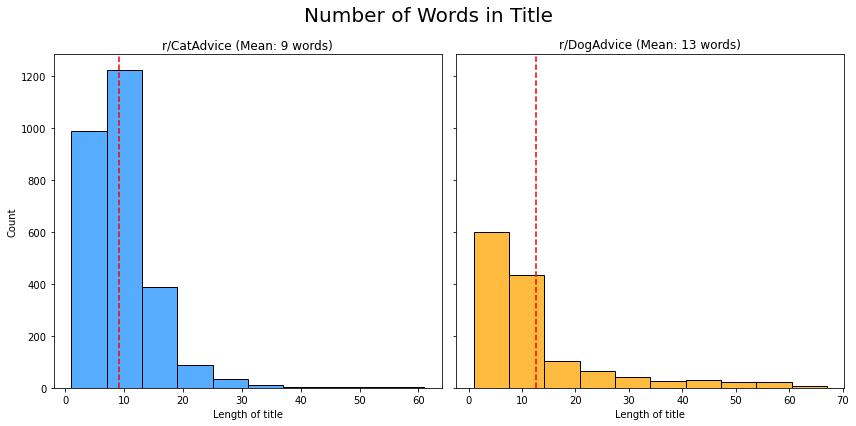

In [72]:
multi_histo('title_length', 'words', 'Length of title', 'words', 'Length of title', 'Number of Words in Title')

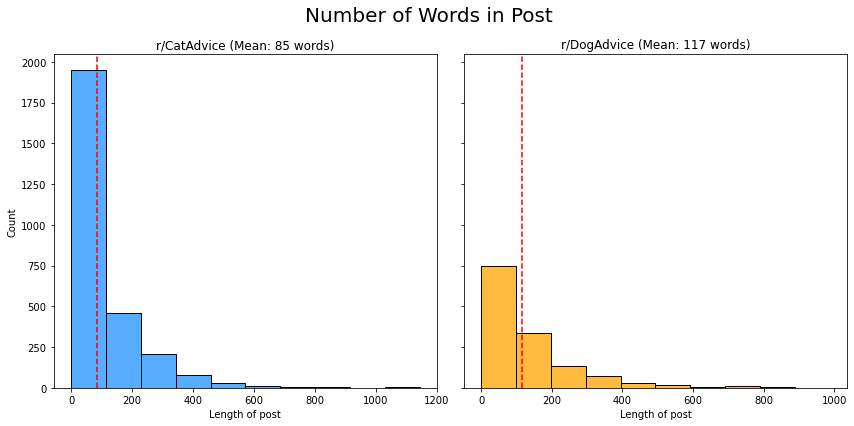

In [73]:
multi_histo('post_length', 'words', 'Length of post', 'words', 'Length of post', 'Number of Words in Post')

Overall, the average length of title and post are shorter in r/CatAdvice compared to r/DogAdvice. Perhaps dog owners are more likely to elaborate the issue faced in detail, which we will dive deeper into during the modeling process. 

In [74]:
# Function to get top words for a singular word, bigram, trigram, four-gram

def top_words(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_words(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','frequency'])
    plt.figure(figsize=(8,8))
    sns.barplot(data=temp_df, y='word', x='frequency', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=20)

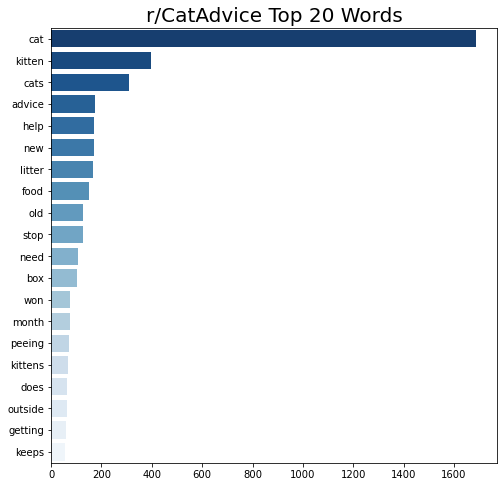

In [75]:
top_words(cat_df, 'title', 20, 1, 'r/CatAdvice Top 20 Words', 'Blues_r')

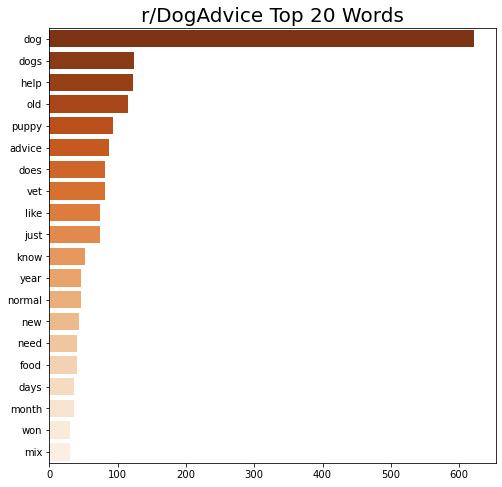

In [76]:
top_words(dog_df, 'title', 20, 1, 'r/DogAdvice Top 20 Words', 'Oranges_r')

Looking at singular words is not very meaningful - words like "cat" or "cats" would naturally emerge as top word used in a r/CatAdvice but this doesn't tell us what are the issues faced by users and what advice they are looking for. The same applies for "dog" or "dogs" in r/DogAdvice.

We'd have to take a closer look at bigrams, trigrams and four-grams to get a better sense of the users' top concerns when sharing in the subreddits.

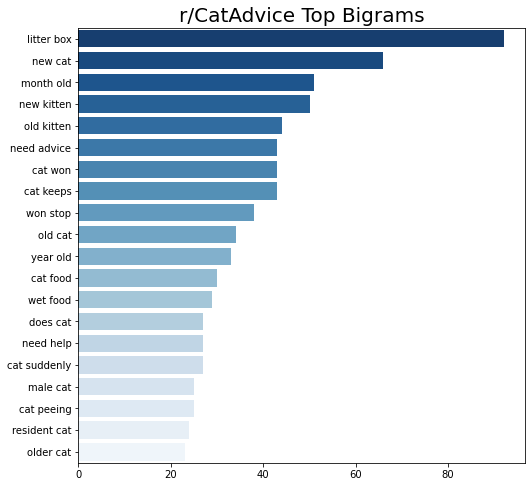

In [77]:
top_words(cat_df, 'title', 20, 2, 'r/CatAdvice Top Bigrams', 'Blues_r')

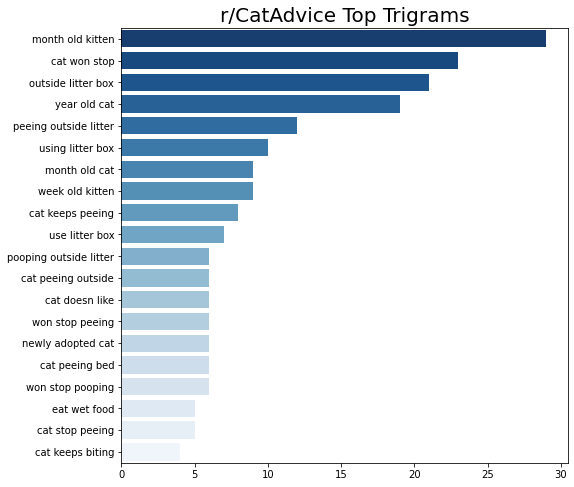

In [78]:
top_words(cat_df, 'title', 20, 3, 'r/CatAdvice Top Trigrams', 'Blues_r')

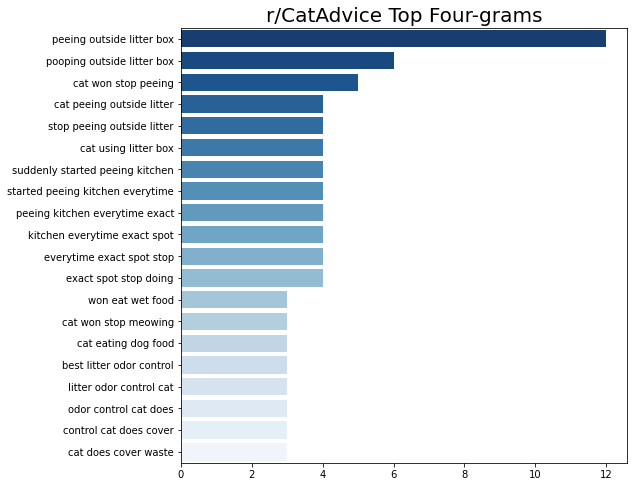

In [79]:
top_words(cat_df, 'title', 20, 4, 'r/CatAdvice Top Four-grams', 'Blues_r')

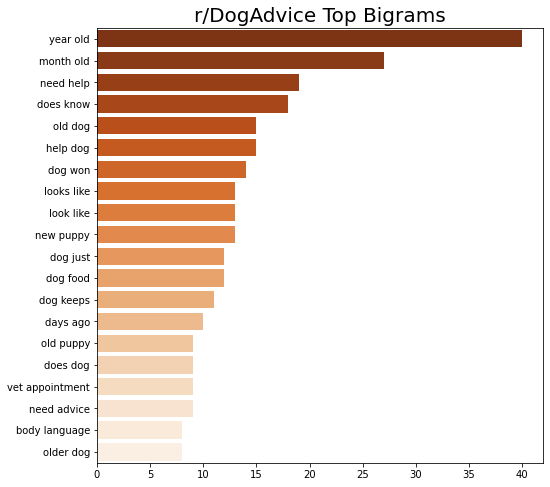

In [80]:
top_words(dog_df, 'title', 20, 2, 'r/DogAdvice Top Bigrams', 'Oranges_r')

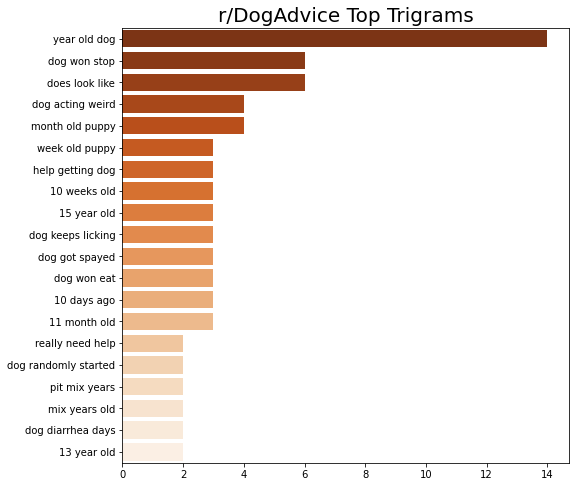

In [81]:
top_words(dog_df, 'title', 20, 3, 'r/DogAdvice Top Trigrams', 'Oranges_r')

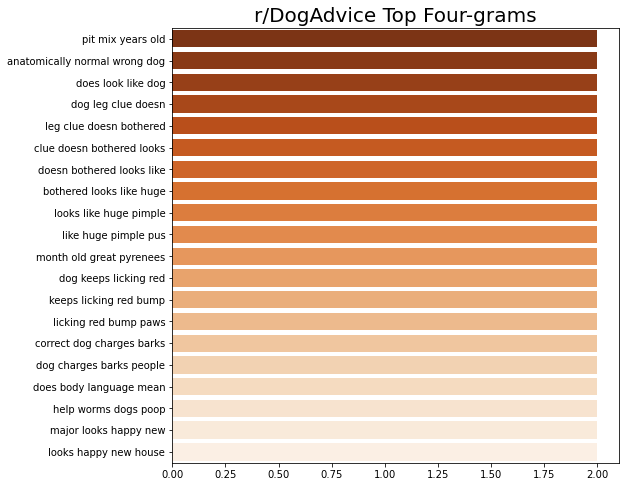

In [82]:
top_words(dog_df, 'title', 20, 4, 'r/DogAdvice Top Four-grams', 'Oranges_r')

Based on the n-gram charts showed above, 
1. Some of the common phrases mentioned in r/CatAdvice include:
    - Issues faced:
        - "Peeing outside litter box"
        - "Cat keeps peeing"
    - Advice on:
        - "Litter box"
        - "Cat food"
        - "Wet food"
    - Age:
        - Most users seek advice for "month old kitten/cat", "year old cat", "new cat"
        - Some of the uses also seek advice for "old cat"
2. Some of the common phrases mentioned in r/DogAdvice include:
    - Issues faced:
        - "Dog acting weird"
        - "Dog keeps licking"
    - Advice on:
        - "Dog food"
        - "Vet appointment"
    - Age:
        - Most users seek advice for "year old", "month old", "new puppy", "year old dog", "month old puppy"
        - Some of the uses also seek advice for "old dog"
3. We can see that most of the issues are behavioral and training.
4. In both r/CatAdvice and r/DogAdvice, users tend to specify the age of their cats and dogs when seeking advice in the community. This indicate that pet owners are conscious in seeking out appropriate care and solution that works for pets at different life stages. We can consider removing "month", "year", "old" keywords to see if there's any impact on modeling.
5. Seeing that in singular word charts, words like "cat", "cats", "dog", "dogs" emerged as most frequent words, we can explore removing these words to see the impact of other words on the model performance. 

In this next part, we'll look how close words are to each other:

### Timing analysis

Apart from the texts, we'll look at the timing of posts to better understand the time of day that users are active. We may be able to include the timing portion in our recommendations.

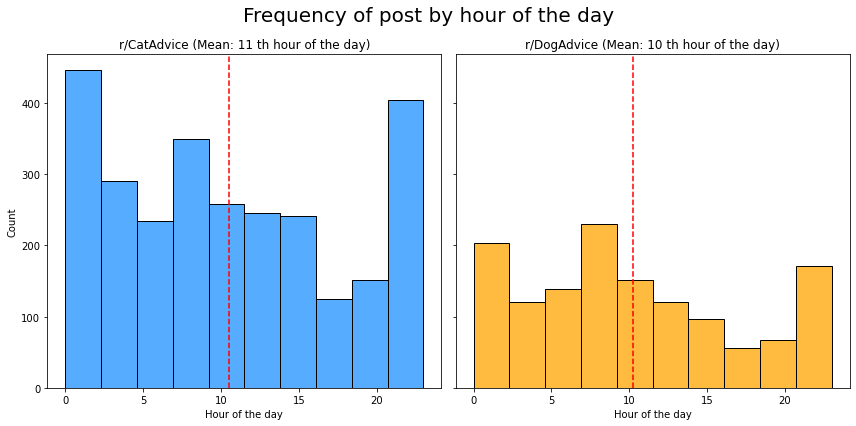

In [83]:
multi_histo('hour', 'th hour of the day', 'Hour of the day', 'th hour of the day', 'Hour of the day', 'Frequency of post by hour of the day')

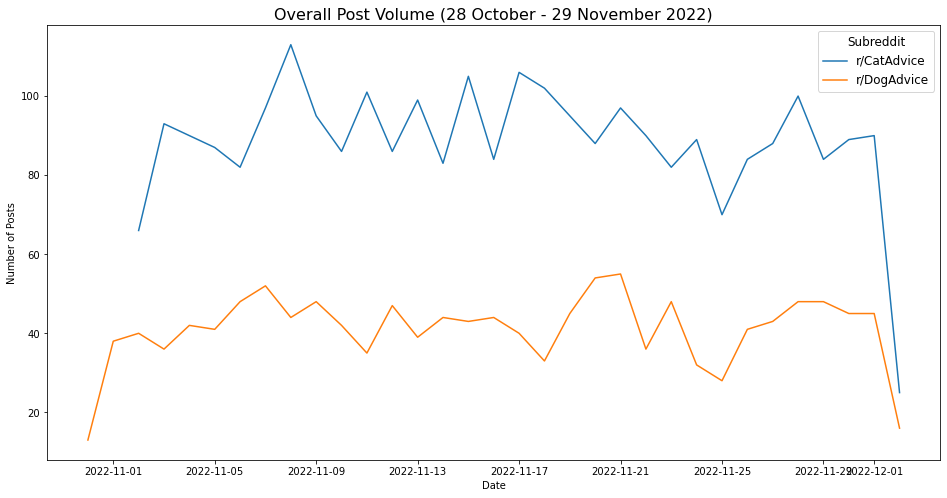

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
cat_df['fulldate'].value_counts().plot()
dog_df['fulldate'].value_counts().plot()
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Overall Post Volume (28 October - 29 November 2022)', fontsize=16)
legend = plt.legend(title='Subreddit', loc='best', labels=['r/CatAdvice', 'r/DogAdvice'], fontsize=12)
legend.get_title().set_fontsize('12')

Based on the timing analysis, 
1. For r/CatAdvice,
    - The average time users post in the subreddit is around 10am
    - The time where most users post is around 12-1am 
2. For r/DogAdvice,
    - The average time users post in the subreddit is around 10am
    - The time where most users post is around 8-10am 
4. We won't compare the volume of posts for the subreddits since we were able to mine more meaningful data from r/CatAdvice - however the time series analysis showed that:
    - The r/CatAdvice had the highest post on 9 November 2022 (Wednesday)
    - The r/DogAdvice had the highest post on 21 November 2022 (Monday)

## Data Preprocessing

In this section, we'll narrow down our features to text data and prepare the dataset for modeling. 

In [85]:
# Taking only relevant columns for processing and combining into one dataframe

cat_df = cat_df[['is_cat', 'title', 'selftext']]
dog_df = dog_df[['is_cat', 'title', 'selftext']]

pets_df = pd.concat([cat_df, dog_df], ignore_index=True, axis=0)

In [86]:
# Check for shape of concatenated dataframes

pets_df.shape

(4099, 3)

### Processing text data

In [87]:
# Function to process and clean the dataset

def preprocessing(text): 
    
    # convert to lowercase
    lower_text = text.lower()
    
    # remove punctuation 
    nopunct_text = re.sub("[^a-z]", " ", lower_text)
    
    # tokenization
    tokens = re.split('\W', nopunct_text)
    
    # lemmatize words
    lemmatized = [wn.lemmatize(word) for word in tokens]
    
    # remove stopwords
    nostop_text = [word for word in tokens if word not in stopwords]
    
    # remove specific words that identifies cat and dog
    pets = ['cat', 'cats', 'kitten', 'kitty', 'dog', 'dogs', 'puppy', 'pup']
    updated_text = [word for word in nostop_text if word not in pets]
    
    # remove specific words that identify age
    age = ['month', 'year', 'young', 'old']
    updated_text_2 = [word for word in updated_text if word not in age]
    
    # remove commonly used words
    common = ['like', 'would', 'want', 'also', 'get', 'got', 'getting', 'none', 'know', 'really', 'since', 'even', 'around', 'still', 'one', 'time', 'day', 'food']
    clean_text = [word for word in updated_text_2 if word not in common]
    
    return (' '.join(clean_text) )

In [88]:
# Combining title and selftext into one column

pets_df['joined_text'] = pets_df['title'] + ' ' + pets_df['selftext']

In [89]:
pets_df['cleaned_text'] = pets_df['joined_text'].map(preprocessing)

In [90]:
pets_df

,is_cat,title,selftext,joined_text,cleaned_text
0,1,Is it cruel to let a cat die at home?,"My bf and I have a cat that we believe is currently dying. His decline has been severe and VERY sudden, in the past 3 days he went from seeming a little bit off to barely breathing. We went to the vet yesterday and we were told that they didn't know what was wrong but it didn't look good. The best they could do would be running $300 of tests just to figure out where to start and even then we were warned that it likely wouldn't be treatable given his symptoms. One of us was just laid off unexpectedly and the last of our cash went to the exam/meds he got yesterday. The cheapest euthanasia price I've found calling around is still $100 we don't have. The cat belongs to my bf who is absolutely devastated and I'm trying to figure out what to do. I've never had a cat before him and my head is still spinning, this whole thing came out of nowhere and I can't understand how things went downhill so fast. We think the cat is 10-12 but don't know for sure since he was a rescue. Right now we've ...","Is it cruel to let a cat die at home? My bf and I have a cat that we believe is currently dying. His decline has been severe and VERY sudden, in the past 3 days he went from seeming a little bit off to barely breathing. We went to the vet yesterday and we were told that they didn't know what was wrong but it didn't look good. The best they could do would be running $300 of tests just to figure out where to start and even then we were warned that it likely wouldn't be treatable given his symptoms. One of us was just laid off unexpectedly and the last of our cash went to the exam/meds he got yesterday. The cheapest euthanasia price I've found calling around is still $100 we don't have. The cat belongs to my bf who is absolutely devastated and I'm trying to figure out what to do. I've never had a cat before him and my head is still spinning, this whole thing came out of nowhere and I can't understand how things went downhill so fast. We think the cat is 10-12 but don't know for sure s...",cruel let die home bf believe currently dying decline severe sudden past days went seeming little bit barely breathing went vet yesterday told wrong look good best could running tests figure start warned likely treatable given symptoms us laid unexpectedly last cash went exam meds yesterday cheapest euthanasia price found calling belongs bf absolutely devastated trying figure never head spinning whole thing came nowhere understand things went downhill fast think sure rescue right made comfortable possible pain heart rate low bpm breathing fast shallow heartbroken help kindness advice go long way us right
1,1,Food recommendations for cats with too-soft stool?,None,Food recommendations for cats with too-soft stool? None,recommendations soft stool
2,1,My 6 mo kitten has some attachment issues and it’s starting to stress me out,None,My 6 mo kitten has some attachment issues and it’s starting to stress me out None,mo attachment issues starting stress
3,1,"Our kitten is an absolute nightmare. We've done everything by the book but he still breaks everything, bites, and keeps us up at night.",None,"Our kitten is an absolute nightmare. We've done everything by the book but he still breaks everything, bites, and keeps us up at night. None",absolute nightmare done everything book breaks everything bites keeps us night
4,1,How often does your cat pee?,None,How often does your cat pee? None,often pee
...,...,...,...,...,...
4094,0,My 8 month old female Jack Russell has a metallic smell coming from her bum,"Hello, please help because my vet wants to charge 850 dollars just to exam and insurance won’t cover it.\n\nI realize this is probably coming from her anal glands, but I just want to know if anyone else has experienced this? I’ve always had boy JRTs and she’s my first female. I always thought the anal gland smell was fishy, but (I think) hers are extremely metallic. She is fixed so I 

In [91]:
# Save cleaned data into csv

pets_df.to_csv('../datasets/pets_preprocessed.csv', index=False)